In [1]:
#import Pkg; Pkg.add("NIfTI")
using NIfTI                  
#import Pkg; Pkg.add("RegressionDynamicCausalModeling")
using RegressionDynamicCausalModeling
using Statistics
#import Pkg; Pkg.add("StatsBase")
using StatsBase #for spearman
#import Pkg; Pkg.add("Plots")
using Plots
using Random

#tries to match the HRF dimensions
#import Pkg; Pkg.add("FFTW")
using FFTW
import Pkg; Pkg.add("Interpolations")
using Interpolations

   Resolving package versions...
  No Changes to `C:\Users\fabia\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\fabia\.julia\environments\v1.11\Manifest.toml`


In [2]:
function extract_timeseries(subject::String; 
                             data_dir::String="/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW", 
                             mask_dir::String="/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/BN_atlas/all_masks_3mm")
    # 1) load rsfMRI
    func_path = joinpath(data_dir, subject, "wFiltered_4DVolume.nii")
    fmri = niread(func_path)                     # NIfTI.jl :contentReference[oaicite:2]{index=2}
    vol4d = fmri.raw                             # raw array dims (X,Y,Z,T)
    T = size(vol4d,4)                            # number of timepoints
    TR = time_step(fmri.header) / 1000           # header dt in ms → seconds

    # 2) list all masks and preallocate
    mask_files = sort(readdir(mask_dir))
    nroi = length(mask_files)
    ts = zeros(nroi, T)

    # 3) loop over masks, extract ROI‐mean
    vol2d = reshape(vol4d, :, T)  # voxels × time
    for (i, mf) in enumerate(mask_files)
        mnii = niread(joinpath(mask_dir, mf))
        mask = mnii.raw .> 0                      # boolean mask :contentReference[oaicite:3]{index=3}
        roi_data = vol2d[vec(mask), :]            # select masked voxels
        ts[i, :] = mean(roi_data; dims=1)[:]      # mean across voxels
    end

    return ts, TR, mask_files
end

extract_timeseries (generic function with 1 method)

In [3]:
function compute_functional_connectivity(ts::AbstractMatrix{<:Real};
                                         method::Symbol = :pearson,
                                         fisher_z::Bool = false)
    nroi, _ = size(ts)
    C = zeros(Float64, nroi, nroi)

    if method == :pearson
        for i in 1:nroi
            for j in i:nroi
                r = cor(ts[i, :], ts[j, :])
                if fisher_z
                    # clamp to avoid infinities
                    r_clamped = clamp(r, -0.9999, 0.9999)
                    val = atanh(r_clamped)
                else
                    val = r
                end
                C[i, j] = val
                C[j, i] = val
            end
        end

    elseif method == :covariance
        # cov(ts') returns ROI×ROI covariance
        C = cov(ts')
    else
        throw(ArgumentError("Unsupported method: $method; choose :pearson or :covariance"))
    end

    return C
end

compute_functional_connectivity (generic function with 1 method)

In [4]:
function estimate_rdcm(ts::Matrix{Float64}, TR::Float64; verbose::Int=1)
    nroi, scans = size(ts)
    #print(scans)

    # 1) endogenous A‐matrix (fully connected minus self‐connections) >> changing to Brainnetome later
    A = trues(nroi, nroi)
    for i in 1:nroi
        A[i,i] = false
    end

    # 2) no driving inputs
    C = falses(nroi, 0)

    # 3) package the BOLD data: expects scans×regions
    Y    = RegressionDynamicCausalModeling.BoldY(ts', TR, nothing)  # :contentReference[oaicite:1]{index=1}

    # 4) no confounds
    r_dt = 16
    u_dt = TR / r_dt
    X_numOfSteps =  round(Int64, scans * TR / u_dt)
    println("X_numOfSteps: ", X_numOfSteps)

    Conf = RegressionDynamicCausalModeling.Confound(zeros(X_numOfSteps, 0), String[])
    println("Confound finished ")

    # 5) zero initial parameters for A and C
    Ep   = RegressionDynamicCausalModeling.TrueParamLinear(
               zeros(nroi, nroi),      # A‐parameters
               zeros(nroi, 0)           # C‐parameters
           )

    # 6) build a LinearDCM and convert to rigid rDCM
    dcm  = RegressionDynamicCausalModeling.LinearDCM(A, C, scans, nroi, nothing, Y, Ep, Conf)
    rdcm = RegressionDynamicCausalModeling.RigidRdcm(dcm)             # :contentReference[oaicite:2]{index=2}

    # 7) set inversion options and invert
    invpars = RegressionDynamicCausalModeling.RigidInversionParams()   # default maxIter, tol
    opt     = RegressionDynamicCausalModeling.Options(invpars; synthetic=false, verbose=verbose)
    output  = RegressionDynamicCausalModeling.invert(rdcm, opt)        # :contentReference[oaicite:3]{index=3}

    return rdcm, output
end


estimate_rdcm (generic function with 1 method)

In [5]:
#starting simple for one subject
subject = "0392851" #"0006315"  # replace with your subject folder name
println("Extract ROIs")
ts, TR, labels = extract_timeseries(subject)



Extract ROIs


([3.0197317600250244 16.350069046020508 … 1.553376317024231 -0.43713998794555664; -0.14135323464870453 0.5262353420257568 … 0.5488901138305664 -0.15290041267871857; … ; -0.14827904105186462 0.5396877527236938 … 0.5346190333366394 -0.1669243723154068; -0.14974643290042877 0.5504797101020813 … 0.5775592923164368 -0.17010065913200378], 2.9000000953674316, ["R001_SFG_7_1_left.nii.gz", "R002_SFG_7_1_right.nii.gz", "R003_SFG_7_2_left.nii.gz", "R004_SFG_7_2_right.nii.gz", "R005_SFG_7_3_left.nii.gz", "R006_SFG_7_3_right.nii.gz", "R007_SFG_7_4_left.nii.gz", "R008_SFG_7_4_right.nii.gz", "R009_SFG_7_5_left.nii.gz", "R010_SFG_7_5_right.nii.gz"  …  "R237_Tha_8_4_left.nii.gz", "R238_Tha_8_4_right.nii.gz", "R239_Tha_8_5_left.nii.gz", "R240_Tha_8_5_right.nii.gz", "R241_Tha_8_6_left.nii.gz", "R242_Tha_8_6_right.nii.gz", "R243_Tha_8_7_left.nii.gz", "R244_Tha_8_7_right.nii.gz", "R245_Tha_8_8_left.nii.gz", "R246_Tha_8_8_right.nii.gz"])

In [6]:
nan_positions = findall(isnan.(ts))
@show nan_positions
@show any(isnan.(ts))

# Create a mask that is true for all rows except row 209
row_mask = [i != 209 for i in 1:size(ts, 1)]

# Apply the mask to exclude the 209th row
ts_noNaN = ts[row_mask, :]

nan_positions = findall(isnan.(ts_noNaN))
@show nan_positions
@show any(isnan.(ts_noNaN))

nan_positions = CartesianIndex{2}[CartesianIndex(209, 1), CartesianIndex(209, 2), CartesianIndex(209, 3), CartesianIndex(209, 4), CartesianIndex(209, 5), CartesianIndex(209, 6), CartesianIndex(209, 7), CartesianIndex(209, 8), CartesianIndex(209, 9), CartesianIndex(209, 10), CartesianIndex(209, 11), CartesianIndex(209, 12), CartesianIndex(209, 13), CartesianIndex(209, 14), CartesianIndex(209, 15), CartesianIndex(209, 16), CartesianIndex(209, 17), CartesianIndex(209, 18), CartesianIndex(209, 19), CartesianIndex(209, 20), CartesianIndex(209, 21), CartesianIndex(209, 22), CartesianIndex(209, 23), CartesianIndex(209, 24), CartesianIndex(209, 25), CartesianIndex(209, 26), CartesianIndex(209, 27), CartesianIndex(209, 28), CartesianIndex(209, 29), CartesianIndex(209, 30), CartesianIndex(209, 31), CartesianIndex(209, 32), CartesianIndex(209, 33), CartesianIndex(209, 34), CartesianIndex(209, 35), CartesianIndex(209, 36), CartesianIndex(209, 37), CartesianIndex(209, 38), CartesianIndex(209, 39), 

false

In [7]:
        nroi, scans = size(ts)

    r_dt = 16
    u_dt = TR / r_dt
    X_numOfSteps =  round(Int64, scans * TR / u_dt)

1760

In [8]:

println("Estimate rDCM")
rdcm, output = estimate_rdcm(ts_noNaN, TR) #TR is 3s. ts  = voxel x time 242x140

#posterior connectivity strengths (A‐matrix) are in `output.m_all`
println("Estimated connectivity parameters (rows=from, cols=to):")
println(output.m_all)

Estimate rDCM
X_numOfSteps: 1760
Confound finished 
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


Estimated connectivity parameters (rows=from, cols=to):
[0.0 0.037217542712129514 -0.10780974769630802 0.0946639963363225 0.020448984938639114 -0.003811123800431915 0.24423387618821835 -0.108874075498548 -0.06529067519463183 -0.13958600334819948 0.03559393758146179 -0.1429138017050775 0.036622382054533276 0.031938314488163755 -0.19901813220340614 -0.0729282833030993 0.09384159436842765 0.32685963795074713 0.2049706655997241 0.04120522627255241 -0.0710151826940546 0.10567395505671584 -0.039173294613092935 -0.06509091724586824 -0.18875909421473125 -0.45212605425541597 0.04219724287570692 -0.06456816551212796 0.05857806122941156 0.03601189702564156 -0.019008274955240267 0.07288690138912557 -0.26809940000111965 -0.037734294034038385 -0.06459279071560786 -0.0044611047305807006 -0.2827076409205631 0.0250092275506546 0.08296310788790606 -0.028506970861940317 0.00963569189127611 -0.25520081238124703 0.1091912664961967 0.21858043762196644 0.14014751248726043 0.03327196636863761 -0.0029559759503

Excessive output truncated after 524295 bytes.

 -0.008019507096859613 0.0023587209282300847 -0.021139808959022233 -0.01325991046444397 -0.03946738462192556 -0.0270930914642058 -0.034843741699205566 0.07558128578440027 -0.012796006983633035 0.043348583786130934 0.011558708979489296 0.0404604407050253 0.040097802774756275 -0.05251132030056034 -0.023464406209853905 0.009814754188813168 -0.002206027084040052 0.012244257618965637 0.018012208086090276 -0.02647658345278714 0.028435213408734117 0.015691763530256253 -0.09435662413225909 0.0016886460713476659 0.004725940620762259 -0.0009950722498892617 -0.000421432986444481 0.01775524078206203 -0.016366593029903953 -0.028309889987556236 -0.06225145017436691 0.012850431357141368 -0.0029176010604432534 0.025038233508450247 -0.08018360089879906 0.00412590608386898 0.023972873482804857 -0.0003986967739352254 -0.02814822701146724 -0.0004797479409957006 -0.015513112102447657 -0.019362246155696816 0.09229399019550799 0.007680352099630028 -0.005683385011025166 -0.0027932782131188105 9.46314296292882

In [9]:
fc_mat = compute_functional_connectivity(ts)              # Pearson r
fc_z   = compute_functional_connectivity(ts; fisher_z=true)  # Fisher-z
cov_mat = compute_functional_connectivity(ts; method=:covariance)  # Covariance

242×242 Matrix{Float64}:
 166.292     6.24156     -14.0347     …  -44.3572     6.33687     6.8256
   6.24156   1.0401       -0.0983642      -2.46927    1.04497     1.131
 -14.0347   -0.0983642    30.254          16.2698    -0.111981   -0.118967
   3.32361  -1.04551      -1.24988         1.37751   -1.03404    -1.12434
 -20.73      0.00196211   26.5994         16.7331    -0.0353527  -0.0239894
 -61.5254   -4.938         9.65331    …   40.6713    -4.92147    -5.36158
  26.2337    3.58234      11.6726         -0.199757   3.60584     3.94532
  11.7541    0.383017     27.7648          9.50338    0.377467    0.404234
  68.6239    4.90729      -2.65842       -11.277      4.94279     5.37258
 -21.7949   -1.90798       2.74426        28.0974    -1.91603    -2.06549
   ⋮                                  ⋱               ⋮          
   6.13141   1.01923      -0.0979557      -2.43346    1.02431     1.10873
 166.799     4.42811     -11.9146         -0.386585   4.35208     4.77653
  16.1109    3.13368

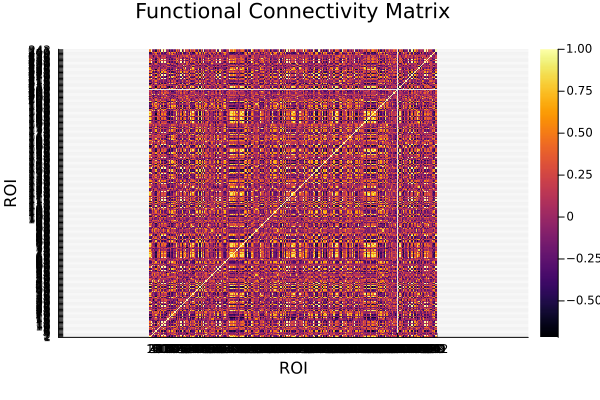

In [10]:
n = size(fc_mat, 1)

heatmap(
    fc_mat;
    aspect_ratio = 1,          # square
    xlabel       = "ROI",      
    ylabel       = "ROI",
    xticks       = (1:n, string.(1:n)),
    yticks       = (1:n, string.(1:n)),
    title        = "Functional Connectivity Matrix",
    colorbar     = true
)